In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

import pandas as pd
#import numpy as np
#from matplotlib import pyplot as plt
#import seaborn as sns
#%pylab inline


# Linear Regression + Data Preparation

In [2]:
Data = pd.read_csv("https://raw.githubusercontent.com/iad34/seminars/master/materials/data_sem1.csv",
                   sep=";")

In [3]:
Data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund; Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen; Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen; Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Data[Data['Age'].isna()]
median_age = Data['Age'].median()

Data['Age'].fillna(median_age, inplace=True)

In [9]:
X = Data[['Pclass', 'Age']].to_numpy()
y = Data['Survived'].to_numpy()

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[:,1] = scaler.fit_transform(X[:,1].reshape(-1,1)).squeeze()

In [11]:
w_ML = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
w_ML

array([0.12436232, 0.00375416])

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(0.9315528888129301, array([-0.23724532, -0.09894954]))

# Gradient Decent + Mini-Batch and Stochastic Gradient Decent 

In [8]:
def plot_3d_GD(fun, a=-1, b=1, c=-1, d=1, trace=None):
    """
    Visualize fun on [a, b] x [c, d]
    
    Optional - line on the surface
    trace : np.array N x 2 - coordinates of the path
    """
    fig = plt.figure()

    # Make grid
    x1_ = np.linspace(a, b, 100)
    x2_ = np.linspace(c, d, 100)
    x1, x2 = np.meshgrid(x1_, x2_)
    y_ = fun(x1, x2)

    # Plot the surface
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(x1, x2, y_, alpha=0.6)
    ax.contour(x1, x2, y_, zdir='z', 
                  offset=y_.min(), cmap=cm.coolwarm)
    
    # Plot 3d line 
    if trace is not None:
        y_trace = fun(trace[:, 0], trace[:, 1])
        ax.plot(trace[:, 0], trace[:, 1], y_trace, "o-")
        ax.plot(trace[:, 0], trace[:, 1], "o-")
        ax.set_xlim(x1.min(), x1.max())
        ax.set_ylim(x2.min(), x2.max())
        ax.set_zlim(y_.min(), y_.max())

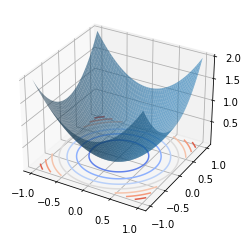

In [9]:
#test
plot_3d_GD(lambda x1, x2: x1**2 + x2**2)

$$
Loss(w_1,w_2) = \frac{1}{n}\sum_{i=1}^{n} (w_1 x_1^{(i)}+w_2 x_2^{(i)}-y^{(i)})^2=\frac{1}{n}(Xw-y)^T(Xw-y)
$$

In [10]:
def loss(w1, w2):
    w = np.array([w1,w2])
    y_ = y.copy()
    for i in range(len(w.shape)-1):
        y_ = np.expand_dims(y_, axis=i+1)
    return np.mean(np.power(np.tensordot(X,w, axes=(1,0)) - y_, 2), axis=0)

$$
\frac{\partial Loss}{\partial w_1} = \frac{2}{n}\sum_{i=1}^{n} x_1^{(i)} (w_1 x_1^{(i)}+w_2 x_2^{(i)}-y^{(i)})= \frac{2}{n}X^T(Xw-y)
$$

In [11]:
def grad_loss(w1, w2):
    w = np.array([w1,w2])  
    return 2*X.T.dot(X.dot(w)-y)/len(y)

In [12]:
def grad_descend(grad_fun, step_size=0.2, num_steps=20):
    """
    * grad_fun - gradient 
    * step_size - learing rate
    * num_steps - number if iterations
    
    Returns np.array (num_steps+1) x 2, 
    the first element is the random initialization
    """
    n_features = 2
    x = np.random.uniform(-4, 4, (n_features))
    d = [x]
    for i in range(num_steps):
        d.append(d[i]-step_size*grad_fun(d[i][0],d[i][1]))
    return np.array(d)

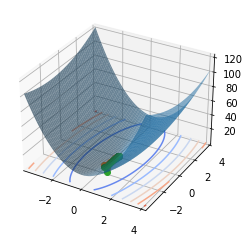

In [13]:
trace = grad_descend(grad_loss, 0.1, 20)
dist = 4
a, b, c, d = w_ML[0]-dist, w_ML[0]+dist, w_ML[1]-dist, w_ML[1]+dist
plot_3d_GD(loss, a, b, c, d, trace=trace)

In [14]:
def plot_gradient(w_list, a=-1, b=1, c=-1, d=1, title=''):
    A, B = np.meshgrid(np.linspace(a, b, 100), np.linspace(c, d, 100))

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss(A[i, j], B[i, j])

    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
    plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)

    # visualize trajectory
    plt.scatter(w_ML[0], w_ML[1], c='r')
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

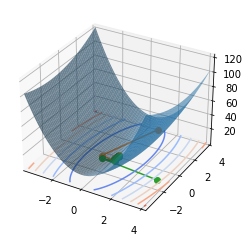

In [15]:
trace = grad_descend(grad_loss, 0.1, 20)
dist = 4
a, b, c, d = w_ML[0]-dist, w_ML[0]+dist, w_ML[1]-dist, w_ML[1]+dist
plot_3d_GD(loss, a, b, c, d, trace=trace)

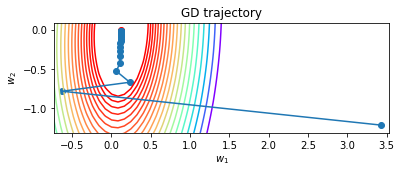

In [16]:
plot_gradient(trace, a, b, c, d, title='GD trajectory')

## SGD/Mini-Batch GD
$$
Loss(w_1,w_2) \approx \frac{1}{M}\sum_{m=1}^{M} (w_1 x_1^{(i_m)}+w_2 x_2^{(i_m)}-y^{(i_m)})^2
$$

In [21]:
def calc_grad_on_batch(X, Y, w, batch_size):
    sample = np.random.randint(2, size=batch_size)
    return 2 * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / batch_size

In [43]:
step_size = 1e-1
num_steps = 40
batch_size = 1
w = np.random.uniform(-4, 4, (2))
w_list = [w.copy()]

for i in range(num_steps):
    w -= step_size * calc_grad_on_batch(X, y, w, batch_size)
    w_list.append(w.copy())

w_list = np.array(w_list)

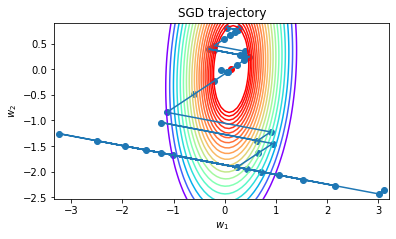

In [44]:
plot_gradient(w_list, a, b, c, d, title='SGD trajectory')

# Polinomial Regression + Pipeline

In [17]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [18]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

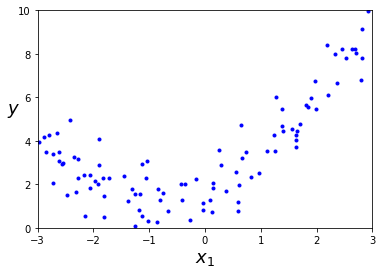

In [20]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [22]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

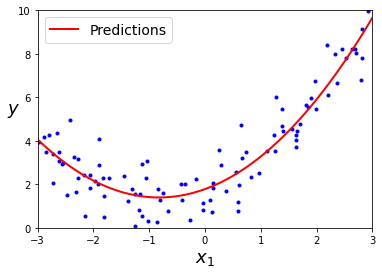

In [24]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])

plt.show()

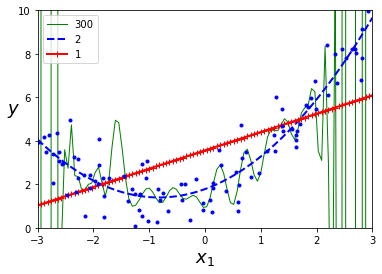

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

# Early Stoping

In [27]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [30]:
from copy import deepcopy
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

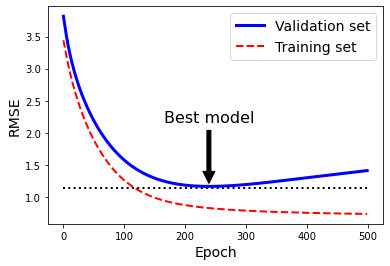

In [32]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [33]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# Logistic Regression

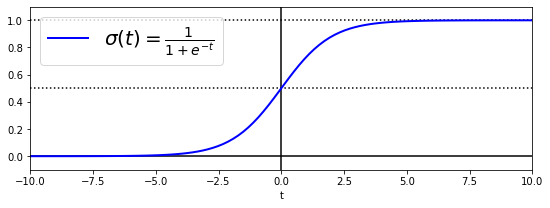

In [35]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

plt.show()

In [36]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [39]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [40]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

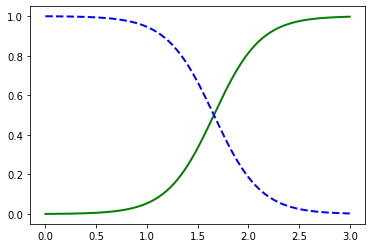

In [41]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

C:\Users\minhk\anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


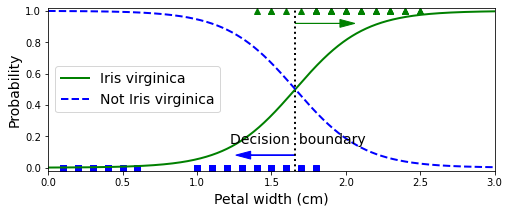

In [46]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

In [47]:
decision_boundary

array([1.66066066])

In [48]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

# Multiclass Classification

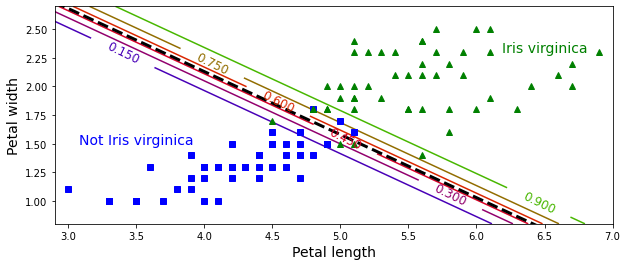

In [49]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

In [50]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

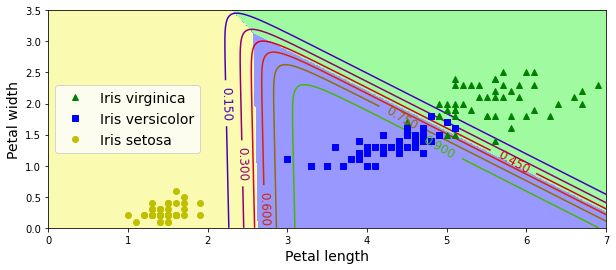

In [51]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()

In [52]:
softmax_reg.predict([[5, 2]])

array([2])

In [53]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])